## FKA122: H2a | Jonatan Haraldsson & Oscar Stommendal - Group 19

### Import statements, constants and general functions

In [24]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as K
import pandas as pd
from IPython.display import display, Markdown

# Latex style
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=20)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
# Set ticks on both sides
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

# Constants
k_B = K.Boltzmann
e = K.elementary_charge
k_B /= e
n_atoms = 2000

# Functions
def read_data(task, T, its_eq=0, its=0):
    if task == 2:
        if its_eq:
            eq_facts = np.genfromtxt(f'data/task_2/equilibrium_{its_eq}_{T}.csv', max_rows=1, delimiter=',', dtype=np.float64)
            eq_data = np.genfromtxt(f'data/task_2/equilibrium_{its_eq}_{T}.csv', delimiter=',', dtype=np.float64)[1:, :]
        else:
            eq_facts = None
            eq_data = None
        if its:
            atoms_data = np.genfromtxt(f'data/task_2/lattice/atoms_{its_eq}_{its}_{T}.csv')
            energy_facts = np.genfromtxt(f'data/task_2/energy_{its_eq}_{its}_{T}.csv', max_rows=2, delimiter=',', dtype=np.float64)[1]
            energy_data = np.genfromtxt(f'data/task_2/energy_{its_eq}_{its}_{T}.csv', delimiter=',', dtype=np.float64, skip_header=3)
        else:
            atoms_data = None
            energy_facts = None
            energy_data = None
    
    return eq_data, eq_facts, atoms_data, energy_data, energy_facts

def plot_burnin(data_eqs, Ts, rows, cols, figsize, save=False, plot_color=None):
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:blue', 'tab:orange', 'tab:green']
    if len(Ts) == 1:
        axs = [axs]
    for i in range(rows):
        for j in range(cols):
            if plot_color:
                axs[i][j].plot(data_eqs[i*cols+j][:, 1], color=plot_color)
            else:
                axs[i][j].plot(data_eqs[i*cols+j][:, 1], color=colors[j])
            axs[0][j].set_title(f'$T = {Ts[i*cols+j]}$ K')
            axs[-1][j].set_xlabel('MC steps')
            axs[i][0].set_ylabel('Potential energy [eV]')
            axs[0][j].set_xticks([0, 1250000, 2500000])
            if j == 0:
                axs[1][j].set_xticks([0, 100000, 200000])
            else:    
                axs[1][j].set_xticks([0, 50000, 100000])

    plt.tight_layout()
    if save:
        plt.savefig('figs/task_3/'+save+'.pdf')
    plt.show()


### Task 1 - Temperature dependence of $P$, $U$ and $C_V$ using Mean Field Theory

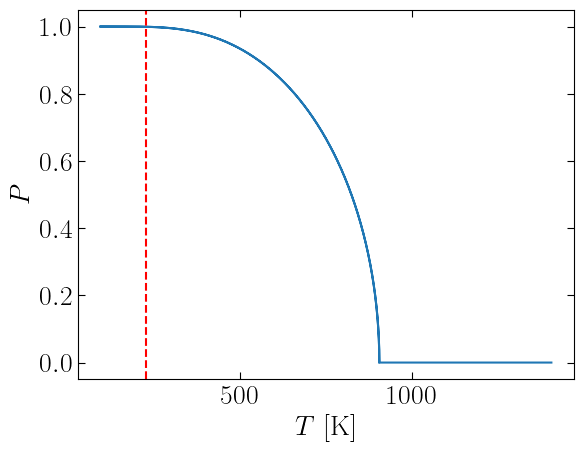

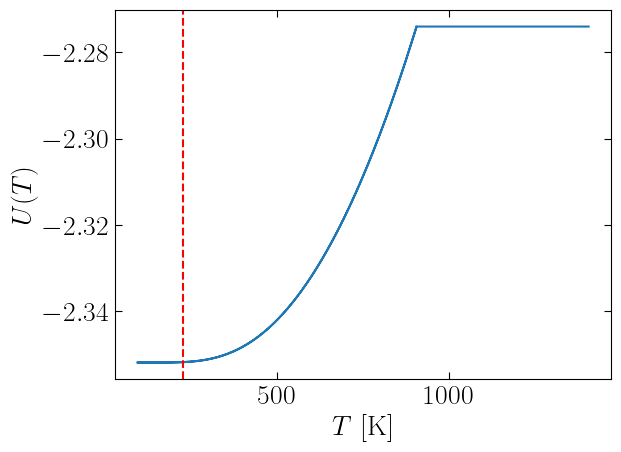

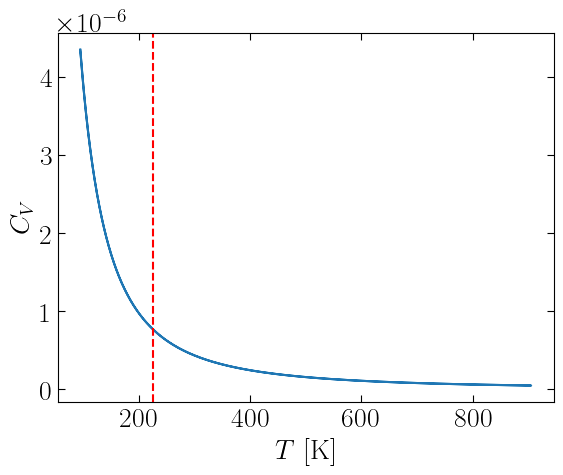

In [31]:

path = 'data/task_1/P_T.csv'
data = np.loadtxt(path, delimiter=',')

E_cucu = -0.436
E_znzn = -0.113
E_cuzn = -0.294
delta_E = E_cucu + E_znzn - 2*E_cuzn
T_c = 0.5*delta_E/k_B
T_over_Tc = np.linspace(np.max(data[:, 1]), np.max(data[:, 1]) + 500, 10000)

plt.figure()
plt.plot(data[:,1],abs(data[:,0]))
plt.plot(T_over_Tc, np.zeros(len(T_over_Tc)), 'tab:blue')
plt.axvline(x=T_c, color='r', linestyle='--')
plt.xlabel('$T$ [K]')
plt.ylabel('$P$')

u_T = 2*(E_cucu + E_znzn + 2*E_cuzn)*np.ones(len(data[:,1])) - 2*data[:,0]**2*delta_E
plt.figure()
plt.plot(data[:,1],u_T)
plt.plot(T_over_Tc, np.ones(len(T_over_Tc))*2*(E_cucu + E_znzn + 2*E_cuzn), 'tab:blue')
plt.axvline(x=T_c, color='r', linestyle='--')
plt.xlabel('$T$ [K]')
plt.ylabel('$U(T)$')

u_fluct = np.mean(u_T**2) - np.mean(u_T)**2
c_V = u_fluct / (k_B * data[:,1]**2)
plt.figure()
plt.plot(data[:,1],c_V)
plt.axvline(x=T_c, color='r', linestyle='--')
plt.xlabel('$T$ [K]')
plt.ylabel('$C_V$')

plt.show()

### Task 2 - Calculating $U$ using the Metropolis Algorithm 

In [14]:

its_eq_400 = 200000
its_eq = 100000
its = 1000000

_, _, atoms_data_400, energy_data_400, energy_facts_400 = read_data(2, 400, its_eq=its_eq_400, its=its)
_, _, atoms_data_600, energy_data_600, energy_facts_600 = read_data(2, 600, its_eq=its_eq, its=its)
_, _, atoms_data_1000, energy_data_1000, energy_facts_1000 = read_data(2, 1000, its_eq=its_eq, its=its)

accept_400_eq = energy_facts_400[1]
accept_600_eq = energy_facts_600[1]
accept_1000_eq = energy_facts_1000[1]
Epot_400 = np.mean(energy_data_400[:, 1])
Epot_600 = np.mean(energy_data_600[:, 1])
Epot_1000 = np.mean(energy_data_1000[:, 1])

df = pd.DataFrame({'$T$': [400, 600, 1000], '$E_{pot}$': [Epot_400, Epot_600, Epot_1000], 
                   '$N_{eq}$': [its_eq_400, its_eq, its_eq], '$\\text{Acceptance}_{eq}$': [accept_400_eq, accept_600_eq, accept_1000_eq]})
md_table = df.to_markdown(index=False)
display(Markdown(md_table))


|   $T$ |   $E_{pot}$ |   $N_{eq}$ |   $\text{Acceptance}_{eq}$ |
|------:|------------:|-----------:|---------------------------:|
|   400 |    -583.909 |     200000 |                   0.018165 |
|   600 |    -563.173 |     100000 |                   0.10111  |
|  1000 |    -520.63  |     100000 |                   0.59238  |

### Task 3

#### a) Temperature dependence of $U$, $C_V$, $P$ and $r$ using MFT

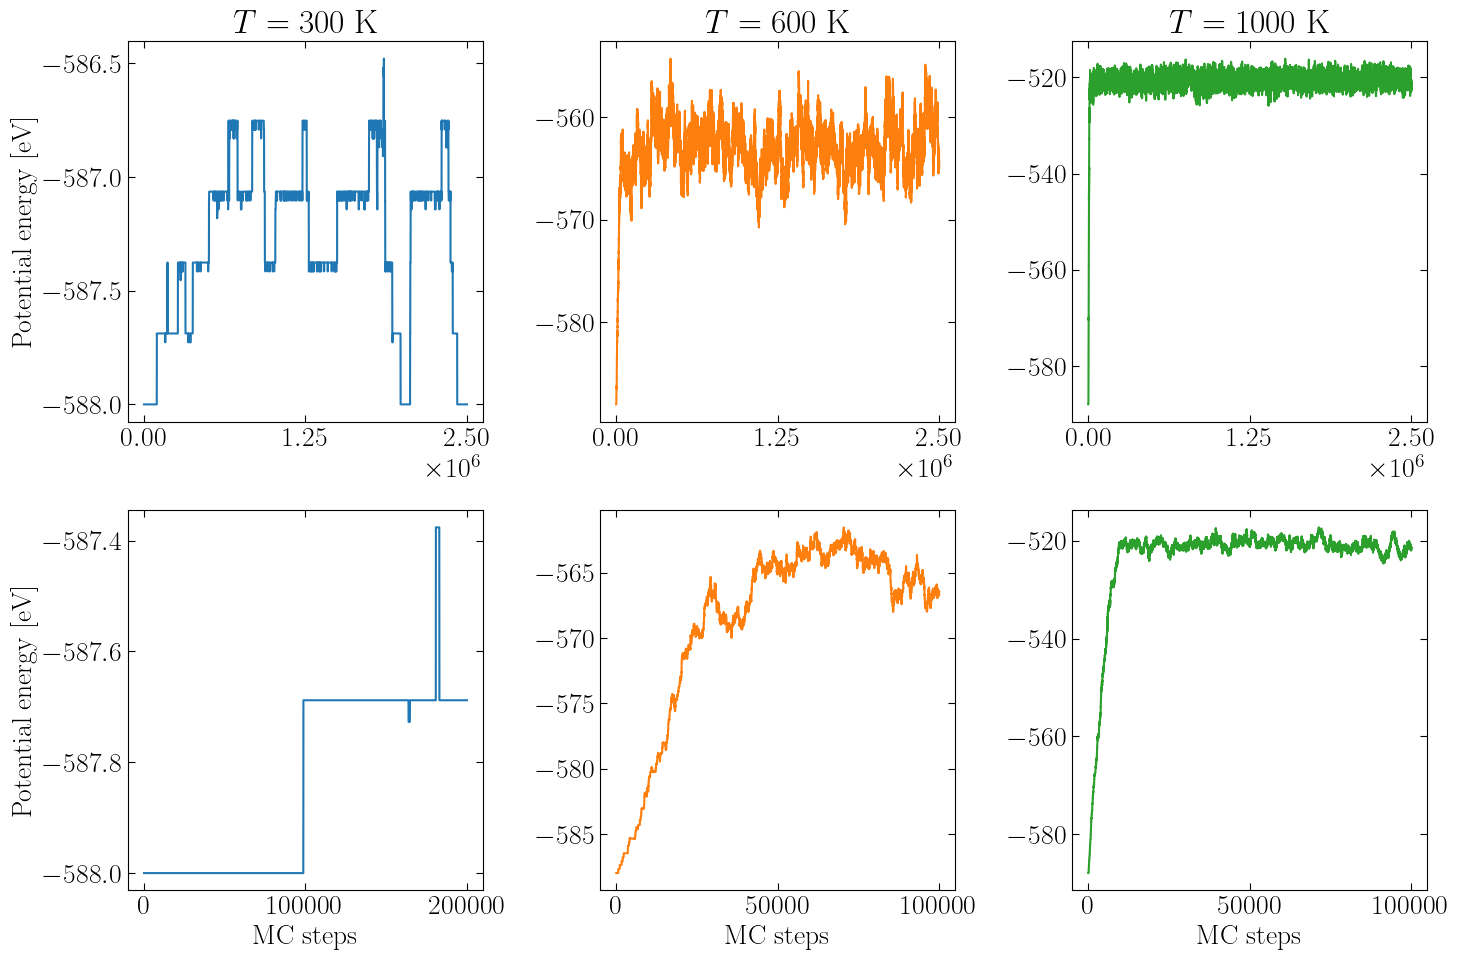

In [ ]:

# Burn-in Traces
its_eq = 2500000

data_eq_300_big, _, _, _, _ = read_data(2, 300, its_eq=its_eq)
data_eq_600_big, _, _, _, _ = read_data(2, 600, its_eq=its_eq)
data_eq_1000_big, _, _, _, _ = read_data(2, 1000, its_eq=its_eq)

its_eq_300 = 200000
its_eq = 100000

data_eq_300, _, _, _, _ = read_data(2, 300, its_eq=its_eq_300)
data_eq_600, _, _, _, _ = read_data(2, 600, its_eq=its_eq)
data_eq_1000, _, _, _, _ = read_data(2, 1000, its_eq=its_eq)

plot_burnin([data_eq_300_big, data_eq_600_big, data_eq_1000_big, data_eq_300, data_eq_600, data_eq_1000], [300, 600, 1000, 300, 600, 1000], 2, 3, (15, 10), save='burnin')


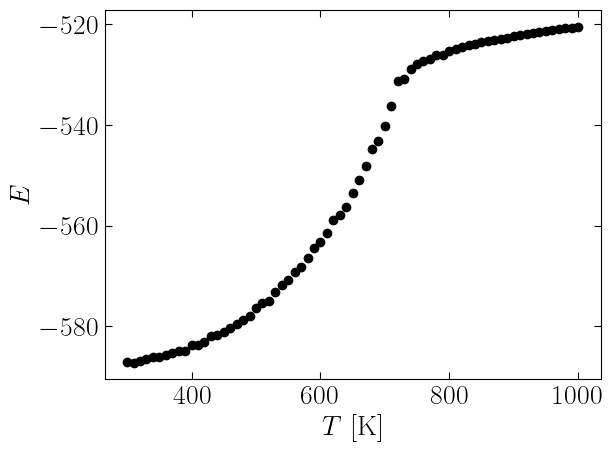

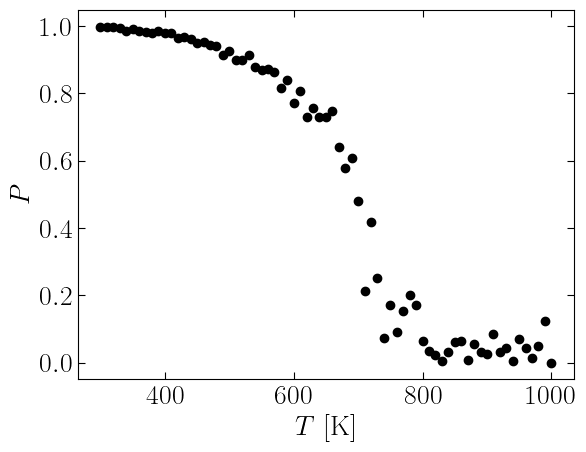

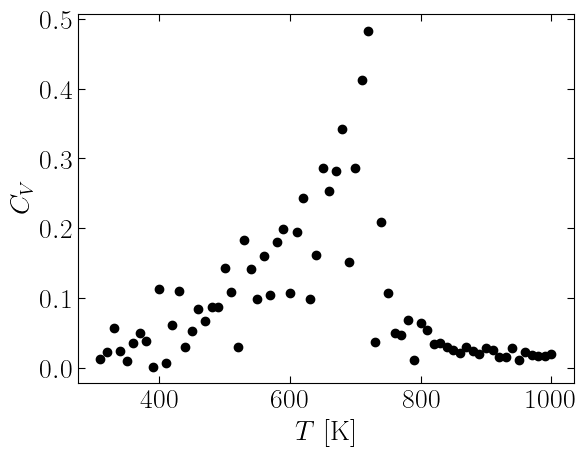

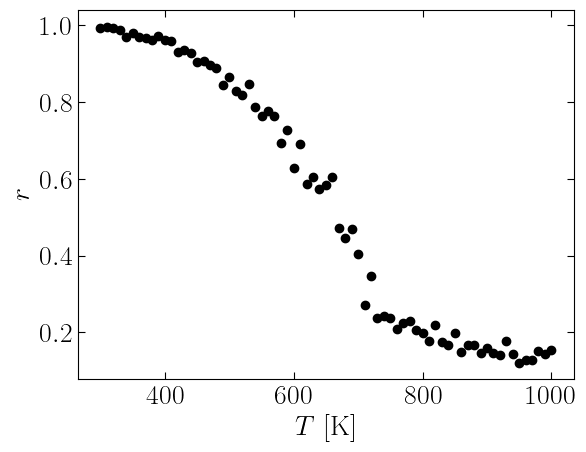

In [81]:
 
data_U = np.genfromtxt('data/task_3/U.csv', delimiter=',', dtype=np.float64)
T = data_U[1:, 0]
E = data_U[1:, 1]

plt.figure()
plt.plot(T, E, 'ko')
plt.xlabel('$T$ [K]')
plt.ylabel('$E$')
plt.show()

data_P_r = np.genfromtxt('data/task_3/P_r.csv', delimiter=',', dtype=np.float64)
T = data_P_r[1:, 0]
N_Cu_A = data_P_r[1:, 1]
P = 2 * N_Cu_A / (n_atoms / 2) - 1

plt.figure()
plt.plot(T, abs(P), 'ko')
plt.xlabel('$T$ [K]')
plt.ylabel('$P$')
plt.show()

E_diff = np.diff(E)
T_diff = np.diff(T)
C_V = E_diff / T_diff

plt.figure()
plt.plot(T[1:], abs(C_V), 'ko')
plt.xlabel('$T$ [K]')
plt.ylabel('$C_V$')
plt.show()

q = data_P_r[1:, 2]
r = 1 / (4 * n_atoms / 2) * (q - 4 * n_atoms / 2)

plt.figure()
plt.plot(T, r, 'ko')
plt.xlabel('$T$ [K]')
plt.ylabel('$r$')
plt.show()


#### b) Error estimation using block average and autocorrelation

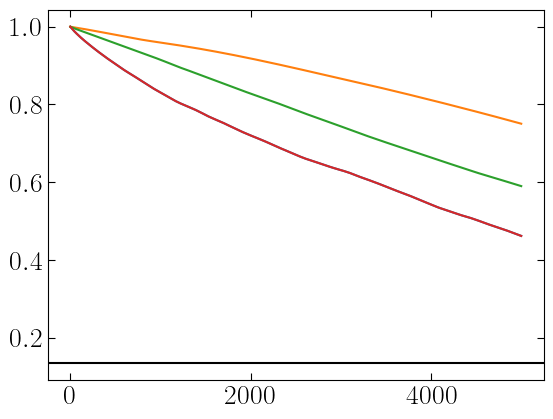

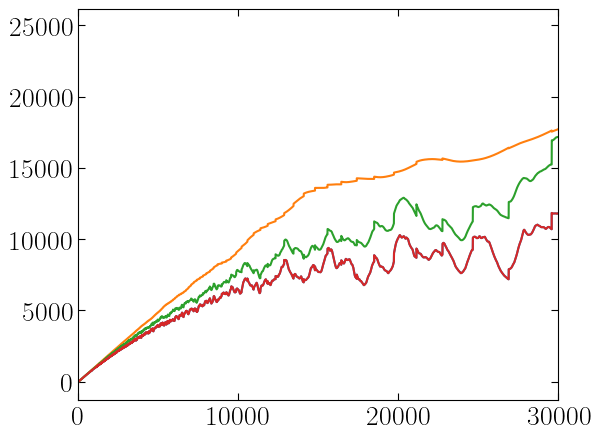

In [85]:

autocorr = np.genfromtxt('data/task_3/auto_corr.csv', delimiter=',', dtype=np.float64)
block = np.genfromtxt('data/task_3/blocking.csv', delimiter=',', dtype=np.float64, skip_header=1)

plt.figure()
plt.plot(autocorr[:, 0], 'tab:blue')
plt.plot(autocorr[:, 1], 'tab:orange')
plt.plot(autocorr[:, 2], 'tab:green')
plt.plot(autocorr[:, 3], 'tab:red')
plt.axhline(np.exp(-2), color='k')

plt.figure()
plt.plot(block[:, 0], block[:, 1], 'tab:blue')
plt.plot(block[:, 0], block[:, 2], 'tab:orange')
plt.plot(block[:, 0], block[:, 3], 'tab:green')
plt.plot(block[:, 0], block[:, 4], 'tab:red')
plt.xlim([0, 30000])

plt.tight_layout()
plt.show()